In [1]:
%cd ..

C:\Users\Cliente\Documents\PAC\cnn


In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from src import data
from src import visualize as vs

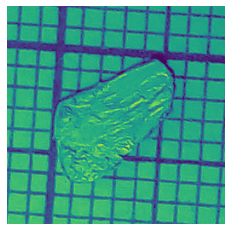

In [78]:
I, G = data.load_random(grayscale=True)
vs.plot_image(I)

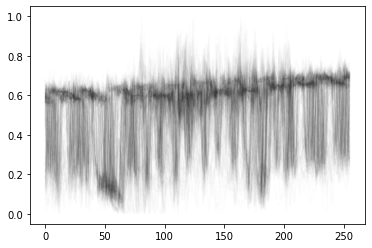

In [79]:
plt.plot(I[0, :, :, 0], 'k-', alpha=0.01)
plt.show()

In [5]:
def FFT(x):
    return np.abs(np.fft.fft(x))

def Cxx(x):
    return np.correlate(x, x, mode='same')

In [80]:
freqs = np.fft.fftfreq(I.shape[-2])
loc = freqs > 0

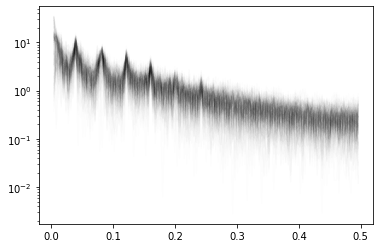

In [81]:
for y in map(FFT, I[0, :, :, 0]):
    plt.semilogy(freqs[loc], y[loc], 'k-', alpha=0.007)
plt.show()

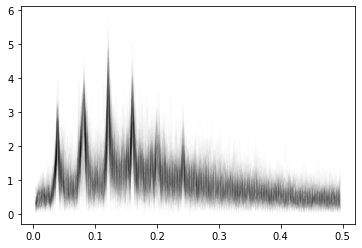

In [82]:
for y in map(FFT, tf.image.image_gradients(I)[1][0, :, :, 0]):
    plt.plot(freqs[loc], y[loc], 'k-', alpha=0.007)
plt.show()

CPU times: total: 391 ms
Wall time: 483 ms


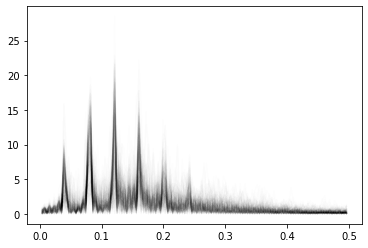

In [83]:
%time F = list(map(lambda x: FFT(Cxx(x)), tf.image.image_gradients(I)[1][0, :, :, 0]))
for y in F:
    plt.plot(freqs[loc], y[loc], 'k-', alpha=0.007)
plt.show()

In [72]:
T = 0.1

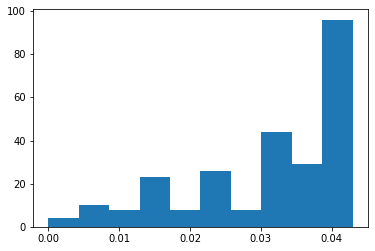

In [84]:
plt.hist([np.abs(freqs[y > tf.reduce_max(y)*T]).min() for y in F])
plt.show()

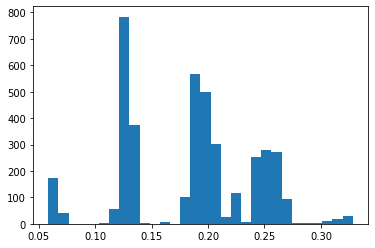

In [69]:
plt.hist(np.concatenate([np.abs(freqs[y > tf.reduce_max(y)*0.5]) for y in F]), bins=30)
plt.show()

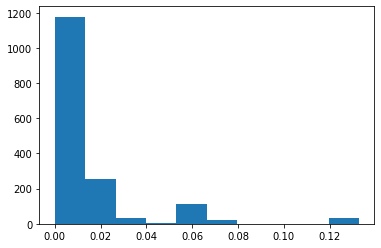

In [76]:
plt.hist(np.concatenate([np.abs(freqs[y > tf.reduce_max(y)*T]) for y in map(FFT, I[0, :, :, 0])]))
plt.show()

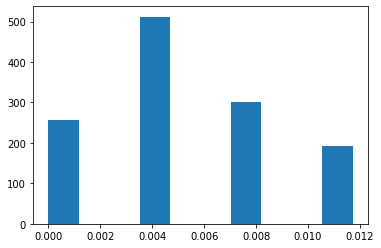

In [77]:
plt.hist(np.concatenate([np.abs(freqs[y > tf.reduce_max(y)*T]) for y in map(lambda x: FFT(Cxx(x)), I[0, :, :, 0])]))
plt.show()

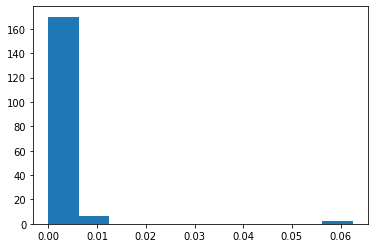

In [48]:
plt.hist(np.concatenate([np.abs(freqs[y > tf.reduce_max(y)*0.1])
          for y in map(FFT, tf.where(G == 0, I, np.nan)[0, :, :, 0])]))
plt.show()